# Analysis of model training with Vision Transformers

## File structure for upload:
First key: Batch size
Second key: run


In [1]:
from keras.datasets   			    import cifar10
from tensorflow.keras 			    import regularizers
from scipy.stats      			    import norm
from IPython.display  			    import clear_output
from google.colab     			    import drive
from keras.models     			    import Sequential
from keras.layers     			    import Dense,Dropout,Activation,Flatten
from keras.layers     			    import Conv1D,MaxPooling1D,Conv2D,MaxPooling2D
from keras.utils      			    import plot_model
from keras.utils      			    import np_utils
from matplotlib.lines               import Line2D
# from hilbertcurve.hilbertcurve	import HilbertCurve

import matplotlib.pyplot  as plt
import numpy              as np
import datetime           as dt
import keras.backend      as k
import sklearn            as skl
import scipy.stats        as stats
import matplotlib.pyplot  as plt
import tensorflow         as tf

import copy
import random
import cv2
import pickle #credits to stack overflow user= blender
import math
import os

savefiles = 0

tf.test.gpu_device_name()

startdate = dt.datetime.now()
timestamp = startdate.strftime('%d%m_%H%M%S')

dataname  = 'cifar10'
# dataname = "imagenette"
modelname = "ViT"
save_data = 1

my_transform_names = ['Hilbert','Dotprint','2D']

# identifier= dataname + '_' + transform
# filename  = identifier+"_"+timestamp

file_location = "$YOUR FILE LOCATION HERE$"
target_dir = "$YOUR TARGET DIRECTORY HERE$"
if os.getcwd().find(file_location) != -1:
    print("Already in proper working directory")
else:
    drive.mount('/content/drive/')
    print("Current location:", os.getcwd())
    os.chdir(file_location)

print("Working directory: %s" %os.getcwd())


Mounted at /content/drive/
Current location: /content
Working directory: /content/drive/MyDrive/AI_Research/Hilbert_AppliedIntelligence/ViT/Cluster_results/Cifar10


In [2]:
def check_hypers(ref_list, new_list):
    for my_key in list(ref_list.keys()):
        if my_key in list(new_list.keys()):
            if new_list[my_key] == ref_list[my_key]:
                continue
            else:
                print("Value difference: %s: %.2f != %.2f" %(my_key, new_list[my_key], ref_list[my_key]))
                return 0
        else:
            print("Key %s not present in target dataframe" %(my_key))
    return 1

In [3]:
def does_exist(substring, stringlist):
    for string in stringlist:
        if string.find(substring) != -1:
            return string
    return 0

def list_exist(substring, stringlist):
    my_names = list()
    for string in stringlist:
        if string.find(substring) != -1:
            my_names.append(string)
    return my_names

### Get transformation name

In [4]:
def get_transform_from_dir(name):
    for my_transform in my_transform_names:
        if name.find(my_transform) != -1:
            return my_transform
    return 0

## Load data from output-files and construct dataframe

In [5]:
def unpack_files(filename, my_file, my_dataframe, my_transform, my_epoch=0):
    if my_epoch:
        print("setting my epoch to fixed selection: %i" %my_epoch)
    else:
        my_epoch = my_file["Hyperparameters"]["Epochs"]
        print("Variable selection of epochs: %i" %my_epoch)

    my_batch = my_file["Hyperparameters"]["Batch"]
    my_run   = my_file["Hyperparameters"]["run"]
    my_lr    = my_file["Hyperparameters"]["lr"]
    my_data  = my_file["Hyperparameters"]["Data"]
    if  my_file["Hyperparameters"]["Transformation"] == "ViT_2D":
        print("%s Has transform %s, setting to 2D" %(filename, my_file["Hyperparameters"]["Transformation"]))
        my_trans = "2D"
    elif my_transform not in my_transform_names:
        print("%s has transform %s that is not in the list of allowed transformations" %(filename, my_transform))
    else:
        my_trans = my_file["Hyperparameters"]["Transformation"]
    if list(my_dataframe.keys()):
        if check_hypers(my_dataframe["Hyperparameters"], my_file["Hyperparameters"]):
            if my_batch in list(my_dataframe.keys()):
                if my_trans in list(my_dataframe[my_batch].keys()):
                    run_counter = max(list(my_dataframe[my_batch][my_trans].keys()))+1
                    my_dataframe[my_batch][my_trans][run_counter] = {}

                    my_dataframe[my_batch][my_trans][run_counter]["train_accuracy"] = my_file["train_accuracy"]
                    my_dataframe[my_batch][my_trans][run_counter]["train_loss"] = my_file["train_loss"]
                    #my_dataframe[my_batch][my_trans][run_counter]["train_top_k_accuracy"] = my_file["train_top_k_accuracy"]

                    my_dataframe[my_batch][my_trans][run_counter]["val_accuracy"] = my_file["val_accuracy"]
                    my_dataframe[my_batch][my_trans][run_counter]["val_loss"] = my_file["val_loss"]
                    #my_dataframe[my_batch][my_trans][run_counter]["val_top_k_accuracy"] = my_file["val_top_k_accuracy"]
                else:
                    run_counter = 0
                    my_dataframe[my_batch][my_trans] = {}
                    my_dataframe[my_batch][my_trans][run_counter] = {}

                    my_dataframe[my_batch][my_trans][run_counter]["train_accuracy"] = my_file["train_accuracy"]
                    my_dataframe[my_batch][my_trans][run_counter]["train_loss"] = my_file["train_loss"]
                    #my_dataframe[my_batch][my_trans][run_counter]["train_top_k_accuracy"] = my_file["train_top_k_accuracy"]

                    my_dataframe[my_batch][my_trans][run_counter]["val_accuracy"] = my_file["val_accuracy"]
                    my_dataframe[my_batch][my_trans][run_counter]["val_loss"] = my_file["val_loss"]
                    #my_dataframe[my_batch][my_trans][run_counter]["val_top_k_accuracy"] = my_file["val_top_k_accuracy"]
            else:
                run_counter = 0
                my_dataframe[my_batch] = {}
                my_dataframe[my_batch][my_trans] = {}
                my_dataframe[my_batch][my_trans][run_counter] = {}

                my_dataframe[my_batch][my_trans][run_counter]["train_accuracy"] = my_file["train_accuracy"]
                my_dataframe[my_batch][my_trans][run_counter]["train_loss"] = my_file["train_loss"]
                #my_dataframe[my_batch][my_trans][run_counter]["train_top_k_accuracy"] = my_file["train_top_k_accuracy"]

                my_dataframe[my_batch][my_trans][run_counter]["val_accuracy"] = my_file["val_accuracy"]
                my_dataframe[my_batch][my_trans][run_counter]["val_loss"] = my_file["val_loss"]
                #my_dataframe[my_batch][my_trans][run_counter]["val_top_k_accuracy"] = my_file["val_top_k_accuracy"]
    else:
        print("No keys in dataframe yet")
        if my_file["Hyperparameters"]["Epochs"] == my_epoch:
            my_dataframe["Hyperparameters"] = {}
            my_dataframe["Hyperparameters"]["Epochs"] = my_epoch
            my_dataframe["Hyperparameters"]["lr"] = my_lr
            my_dataframe["Hyperparameters"]["Data"] = my_data

            run_counter = 0

            my_dataframe[my_batch] = {}
            my_dataframe[my_batch][my_trans] = {}
            my_dataframe[my_batch][my_trans][run_counter] = {}
            # np array works, but easier initially to analyse dict
            # my_dataframe[my_batch][my_trans][run_counter] = np.array([my_file["train_accuracy"],my_file["val_accuracy"],my_file["train_loss"],my_file["val_loss"],my_file["test_accuracy"]])
            my_dataframe[my_batch][my_trans][run_counter]["train_accuracy"] = my_file["train_accuracy"]
            my_dataframe[my_batch][my_trans][run_counter]["train_loss"] = my_file["train_loss"]
            #my_dataframe[my_batch][my_trans][run_counter]["train_top_k_accuracy"] = my_file["train_top_k_accuracy"]

            my_dataframe[my_batch][my_trans][run_counter]["val_accuracy"] = my_file["val_accuracy"]
            my_dataframe[my_batch][my_trans][run_counter]["val_loss"] = my_file["val_loss"]
            #my_dataframe[my_batch][my_trans][run_counter]["val_top_k_accuracy"] = my_file["val_top_k_accuracy"]
    return my_dataframe
#    my_dataframe[my_batch][run_counter] = np.array(my_file["Training_accuracy"],my_file["validation_accuracy"],my_file["training_loss"],my_file["validation_loss"],my_file["test_accuracy"])

## Set selection of hyperparameters (optional)

## Load data from files

In [6]:
my_dataset = {}

if os.getcwd().find(file_location) != -1:
    print("Already in proper working directory")
else:
    os.chdir(file_location)

my_dirs = list()
my_dirs = list_exist(dataname, os.listdir())
print(my_dirs)

if my_dirs:
    for my_dir in my_dirs:
        transform = get_transform_from_dir(my_dir)
        if transform:
            print("Transformation: ", transform)
            os.chdir(my_dir)
            file_names = list_exist("Features", os.listdir())
            for my_file in file_names:
                print("Unpacking file %s from directory %s" %(my_file, my_dir))
                with (open(my_file,"rb")) as handle:
                    my_results = pickle.load(handle)
                    handle.close()
                ## Get hyperparameters from datafile
                epochs = my_results['Hyperparameters']["Epochs"]
                # epochs = 150
                ## unpack datafile
                my_dataset = unpack_files(my_file, my_results, my_dataset, transform, my_epoch = epochs)
                del(my_results)
            os.chdir("..")
        else:
            print("Transformation of directory %s not found in allowed list" %my_dir)
else:
    print("No data directories for dataset %s found in working directory %s" %(dataname, os.listdir()))


Already in proper working directory
['ViT_cifar10_Dotprint_2605_182357', 'ViT_cifar10_Hilbert_2605_182052', 'ViT_cifar10_2D_2905_Gathered', 'cifar10_ViT_Results.pdf', 'cifar10_ViT_Averaged.pdf', 'cifar10_ViT_Differences.pdf', 'cifar10_ViT_validationGap.pdf']
Transformation:  Dotprint
Unpacking file Features_2.dat from directory ViT_cifar10_Dotprint_2605_182357
setting my epoch to fixed selection: 10
No keys in dataframe yet
Unpacking file Features_1.dat from directory ViT_cifar10_Dotprint_2605_182357
setting my epoch to fixed selection: 10
Unpacking file Features_4.dat from directory ViT_cifar10_Dotprint_2605_182357
setting my epoch to fixed selection: 10
Unpacking file Features_0.dat from directory ViT_cifar10_Dotprint_2605_182357
setting my epoch to fixed selection: 10
Unpacking file Features_3.dat from directory ViT_cifar10_Dotprint_2605_182357
setting my epoch to fixed selection: 10
Unpacking file Features_11.dat from directory ViT_cifar10_Dotprint_2605_182357
setting my epoch to f

In [7]:
print(my_dirs)

['ViT_cifar10_Dotprint_2605_182357', 'ViT_cifar10_Hilbert_2605_182052', 'ViT_cifar10_2D_2905_Gathered', 'cifar10_ViT_Results.pdf', 'cifar10_ViT_Averaged.pdf', 'cifar10_ViT_Differences.pdf', 'cifar10_ViT_validationGap.pdf']


## Dataframe check

In [8]:
print("First level: ", my_dataset.keys())
print("batch 50: ",my_dataset[50].keys())

First level:  dict_keys(['Hyperparameters', 10, 50, 20])
batch 50:  dict_keys(['Dotprint', 'Hilbert', '2D'])


## Analysis

In [9]:
my_epochs = my_dataset["Hyperparameters"]["Epochs"]

my_batches = list(my_dataset.keys())[1:]
my_transforms = list(my_dataset[my_batches[0]].keys())
my_runs = list(my_dataset[my_batches[0]][my_transforms[0]].keys())
my_metrics = list(my_dataset[my_batches[0]][my_transforms[0]][my_runs[0]].keys())

In [10]:
# print(len(my_dataset[my_batches[0]][my_transforms[0]][my_runs[0]][my_metrics[0]]))
print(my_batches)
print(my_transforms)
print(my_runs)
print(my_metrics)

[10, 50, 20]
['Dotprint', 'Hilbert', '2D']
[0, 1, 2, 3, 4]
['train_accuracy', 'train_loss', 'val_accuracy', 'val_loss']


## Rename Dotprint to Flatten

In [11]:
all_transforms = list()

for key in list(my_dataset.keys()):
    for my_key in list(my_dataset[key].keys()):
        if my_key == "Dotprint":
            my_dataset[key]["Flatten"] = my_dataset[key]["Dotprint"]
            del(my_dataset[key]["Dotprint"])
            all_transforms.append('Flatten')
        else:
            all_transforms.append(my_key)
    print (my_dataset[key].keys())

my_transform_names = ['Hilbert','Flatten']
my_transforms = ['Hilbert','2D','Flatten']
# print(my_transforms)

dict_keys(['Epochs', 'lr', 'Data'])
dict_keys(['Hilbert', '2D', 'Flatten'])
dict_keys(['Hilbert', '2D', 'Flatten'])
dict_keys(['Hilbert', '2D', 'Flatten'])


### Set Metrics

In [12]:
print(len(list(my_dataset.keys())[1:]), my_metrics)
my_metrics = [my_metrics[0],my_metrics[2]]
print(my_metrics)

3 ['train_accuracy', 'train_loss', 'val_accuracy', 'val_loss']
['train_accuracy', 'val_accuracy']


# Visualization

In [13]:
from matplotlib.lines import Line2D
# Figure Formatting:
####################
def set_figure_size(row, col):
    width = 17.5*int(row/2)+1
    height= 8*int(col/2)+1
    return (width,height)

figure_size = (17.5,8)

# font sizes
fs = 20 #fontsize
ts = 25 #titlesize
ls = 15 #legendsize
tick_size = 15

# visual settings
ms = 10
lw = 2

# Markers and linetypes
my_markers = ['o','s','p','h','+','x','v','>','<','^']
line_styles = ["solid","dashed","dotted","dashdot"]
my_colors = ["C0","C9", "C3","C6","C2","C8"]

# Unified parameters:
markers = {}
markers["Hilbert"] = ["o","D","v"]
markers["Flatten"] = ["s","^",">"]
markers["2D"]      = ["p","*","X"]
colors = {}
colors["Hilbert"] = [(106/256,139/256,206/256), (141/256, 173/256, 63/256), (132/256, 119/256, 175/256)]
colors["Flatten"] = [(226/256, 157/256, 36/256),(238/256, 93/256, 38/256),(170/256, 132/256, 87/256)]
colors["2D"]      = ["C9", "C6", 'black']
lines = {}
lines["Hilbert"] = ("solid","dashed","dotted")
lines["Flatten"] = ("solid","dashed","dotted")
lines["2D"] = ("solid","dashed","dotted")

legend_labels = {}

m_it = 0
for my_transform in my_transforms:
    m_it = 0
    legend_labels[my_transform + modelname] = {}
    legend_labels[my_transform + modelname]["label"] = "%s- Model %s" %(my_transform,modelname)
    legend_labels[my_transform + modelname]["color"] = colors[my_transform][m_it]
    legend_labels[my_transform + modelname]["marker"] = markers[my_transform][m_it]
    legend_labels[my_transform + modelname]["linetype"] = lines[my_transform][m_it]
    m_it+=1

# Axis labels:
my_metric_name = {}
my_metric_name["train_accuracy"]       = "training accuracy"
my_metric_name["train_loss"]           = "training loss"
my_metric_name["train_top_k_accuracy"] = "training top-5 accuracy"
my_metric_name["val_accuracy"]         = "validation accuracy"
my_metric_name["val_loss"]             = "validation loss"
my_metric_name["val_top_k_accuracy"]   = "validation top-5 accuracy"

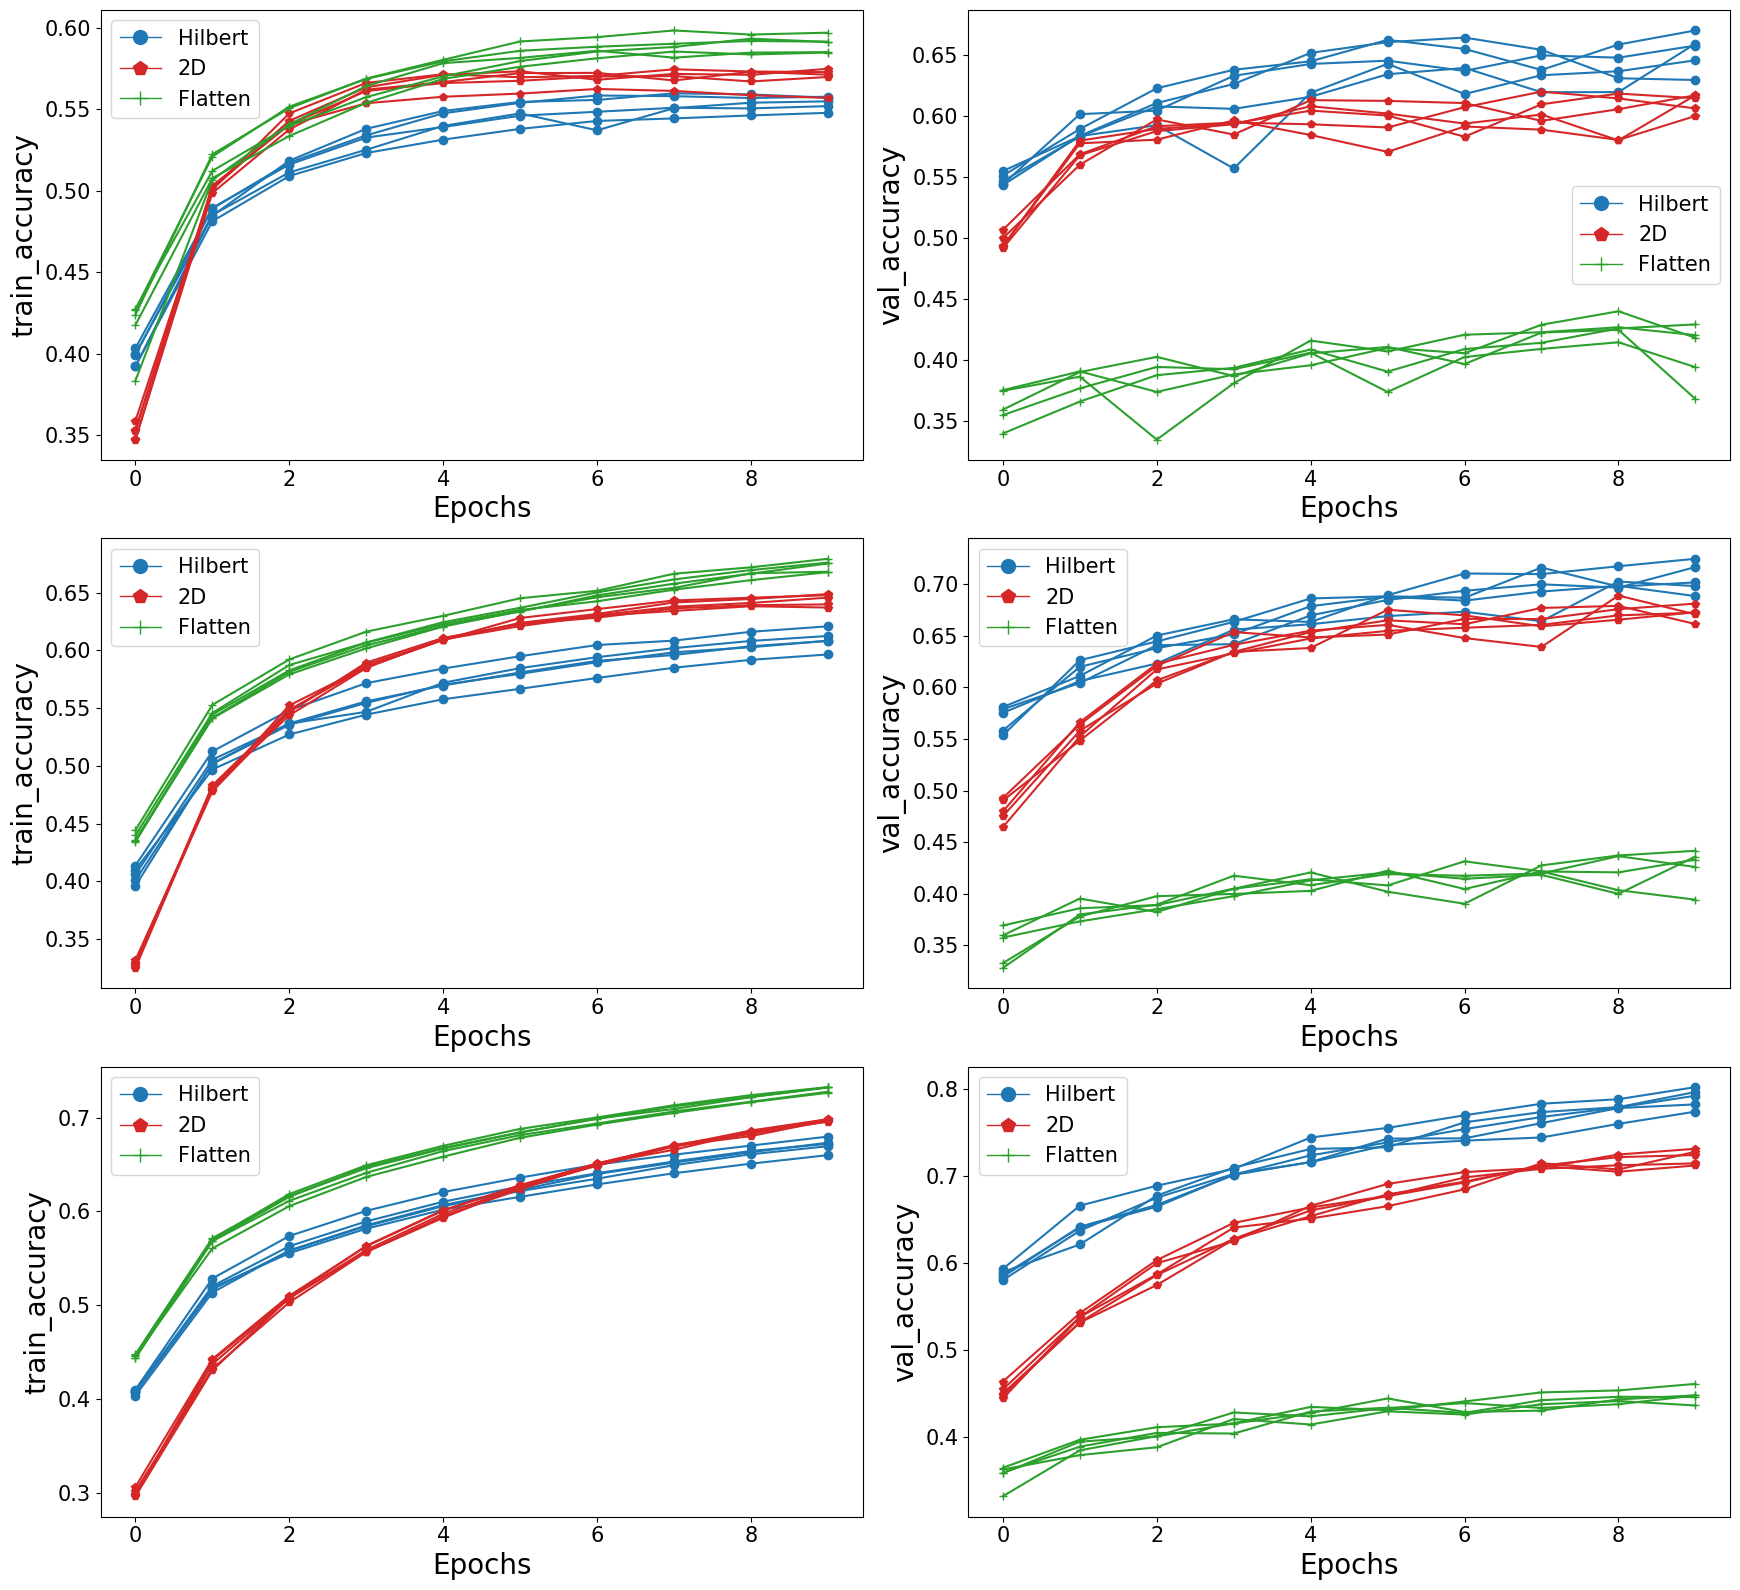

In [14]:
# fig, axs = plt.subplots(len(my_batches),len(my_metrics[:-1]), figsize= set_figure_size(len(my_batches),len(my_metrics[:-1])))
# if len(my_batches) > 1:
#     fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (len(my_batches)/2*17.5,3*7))
# else:
#     fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (2*17.5,8))
fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (17.5,2*8))

row_nb = 0
col_nb = 0

for my_batch in sorted(my_batches):
    color_index = 0
    col_nb = 0
    my_transforms = list(my_dataset[my_batch].keys())
    for my_metric in my_metrics:
        legend_string = list()
        color_index = 0
        for my_transform in my_transforms:
            my_runs = list(my_dataset[my_batch][my_transform].keys())
            line_index = 0
            # print(my_runs)
            for my_run in my_runs:
                ## Transformation 1
                if len(my_batches) > 1:
                    axs[row_nb][col_nb].plot(
                        range(my_epochs),
                        my_dataset[my_batch][my_transform][my_run][my_metric],
                        color = my_colors[color_index],
                        linestyle = line_styles[line_index],
                        marker = my_markers[color_index],
                        # label = my_transform
                        )
                else:
                    axs[col_nb].plot(
                        range(my_epochs),
                        my_dataset[my_batch][my_transform][my_run][my_metric],
                        color = my_colors[color_index],
                        linestyle = line_styles[line_index],
                        marker = my_markers[color_index],
                        # label = my_transform
                        )

            legend_string.append(Line2D([0], [0],
                                color = my_colors[color_index],
                                linestyle = line_styles[line_index],
                                marker = my_markers[color_index],
                                markersize = ms,
                                lw=1,
                                # label="%s- Runs: %i" %(my_transform,len(my_runs))
                                label="%s" %my_transform
                                )
            )
            color_index += 2
            if line_index:
                line_index = 0
            else:
                line_index = 1

            if len(my_batches) > 1:
                # axs[row_nb][col_nb].set_title(dataname+"\nBatchsize: %i - %s" %(my_batch, my_metric), fontsize=ts)
                axs[row_nb][col_nb].set_xlabel("Epochs", fontsize=fs)
                axs[row_nb][col_nb].set_ylabel(my_metric, fontsize=fs)
                axs[row_nb][col_nb].tick_params(axis='both', labelsize=tick_size)
                axs[row_nb][col_nb].legend(handles=legend_string, frameon=True, loc='best', fontsize=ls)
                # axs[row_nb][col_nb].legend(fontsize=ls)
            else:
                # axs[col_nb].set_title(dataname+"\nBatchsize: %i - %s" %(my_batch, my_metric), fontsize=ts)
                axs[col_nb].set_xlabel("Epochs", fontsize=fs)
                axs[col_nb].set_ylabel(my_metric, fontsize=fs)
                axs[col_nb].tick_params(axis='both', labelsize=tick_size)
                axs[col_nb].legend(handles=legend_string, frameon=True, loc='best', fontsize=ls)
                # axs[row_nb][col_nb].legend(fontsize=ls)

        col_nb += 1
    row_nb += 1

fig.tight_layout()

if save_data:
    fig.savefig(dataname+"_"+modelname+"_Results.pdf", format='pdf', dpi = 100, bbox_inches="tight")

fig.show()


## Averaged results

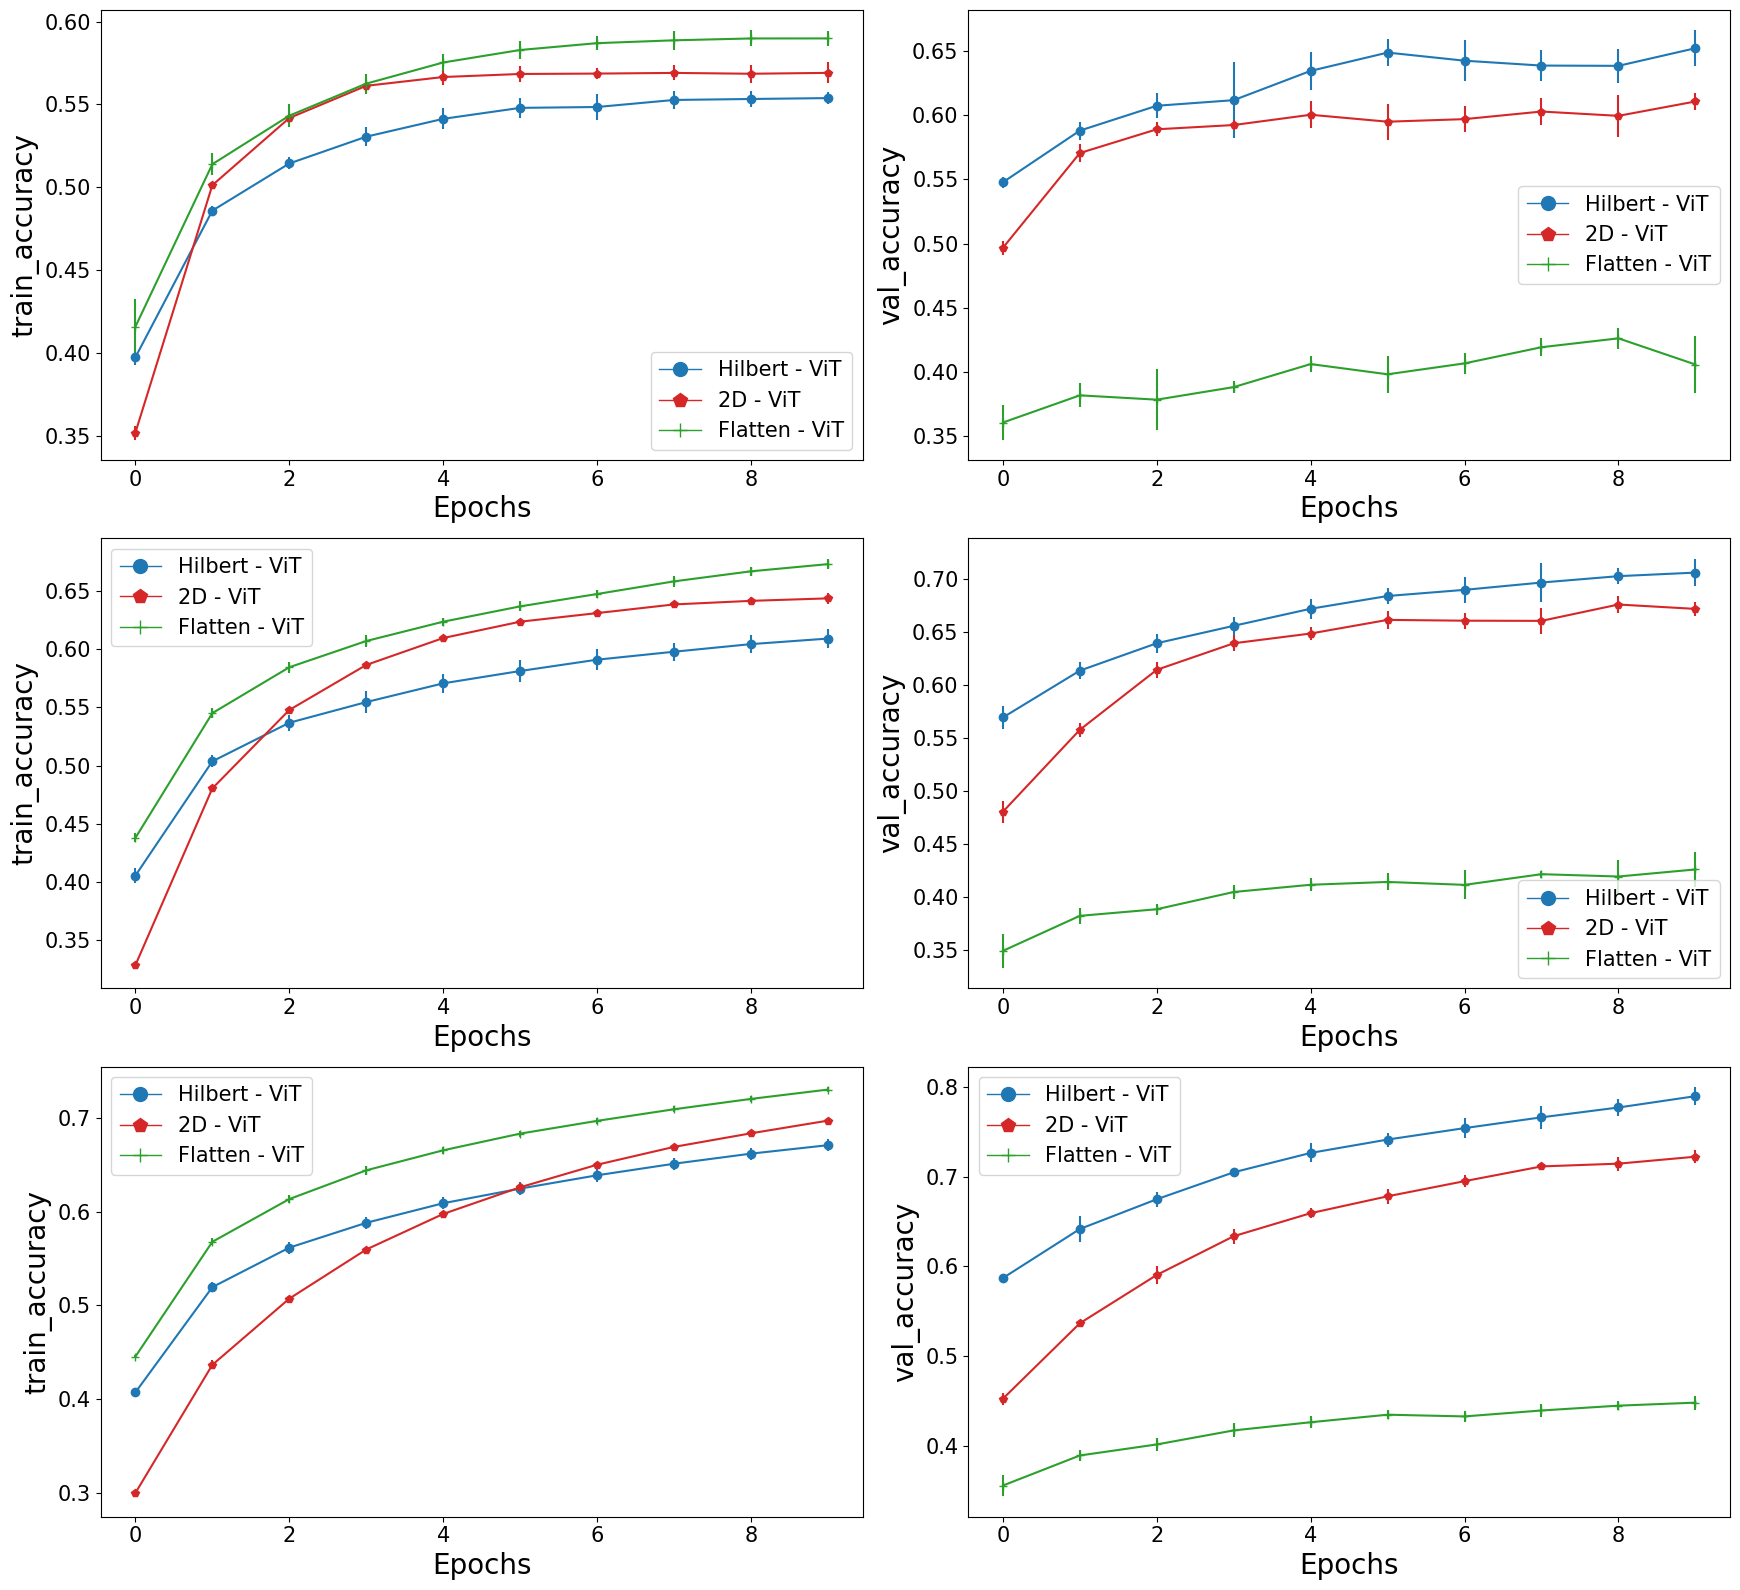

In [15]:
# fig, axs = plt.subplots(len(my_batches),len(my_metrics[:-1]), figsize= set_figure_size(len(my_batches),len(my_metrics[:-1])))
# if len(my_batches) > 1:
#     fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (len(my_batches)/2*17.5,2*9))
# else:
#     fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (2*17.5,8))
fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (17.5,2*8))

row_nb = 0
col_nb = 0

expected_values  = {}
variation_values = {}

averages = {}

for my_batch in sorted(my_batches):
    color_index = 0
    col_nb = 0
    my_transforms = list(my_dataset[my_batch].keys())
    expected_values[my_batch]  = {}
    variation_values[my_batch] = {}
    averages[my_batch] = {}
    for my_metric in my_metrics:
        legend_string = list()
        color_index = 0
        expected_values[my_batch][my_metric]  = {}
        variation_values[my_batch][my_metric] = {}
        averages[my_batch][my_metric] = {}
        for my_transform in my_transforms:
            my_runs = list(my_dataset[my_batch][my_transform].keys())
            expected_values[my_batch][my_metric][my_transform]  = list()
            variation_values[my_batch][my_metric][my_transform] = list()

            # for my_run in my_runs:
                ## Transformation 1
            my_epochs = len(my_dataset[my_batch][my_transform][my_runs[0]][my_metric])
            exp_vals = list()
            var_vals = list()
            line_index = 0
            for my_range in range(my_epochs):
                my_exp_val, my_var = norm.fit([my_dataset[my_batch][my_transform][my_run][my_metric][my_range] for my_run in my_runs])
                exp_vals.append(my_exp_val)
                var_vals.append(my_var)

            averages[my_batch][my_metric][my_transform] = np.stack((exp_vals, var_vals))
            if len(my_batches) > 1:
                axs[row_nb][col_nb].errorbar(
                    range(my_epochs),
                    exp_vals,
                    var_vals,
                    color = my_colors[color_index],
                    linestyle = line_styles[line_index],
                    marker = my_markers[color_index],
                    # label = my_transform
                    )
            else:
                axs[col_nb].errorbar(
                    range(my_epochs),
                    exp_vals,
                    var_vals,
                    color = my_colors[color_index],
                    linestyle = line_styles[line_index],
                    marker = my_markers[color_index],
                    # label = my_transform
                    )
            expected_values[my_batch][my_metric][my_transform]  = exp_vals
            variation_values[my_batch][my_metric][my_transform] = var_vals

            legend_string.append(Line2D([0], [0],
                                color = my_colors[color_index],
                                linestyle = line_styles[line_index],
                                marker = my_markers[color_index],
                                markersize = ms,
                                lw=1,
                                label="%s - %s" %(my_transform, modelname)
                                )
            )
            color_index += 2

            if len(my_batches) > 1:
                # axs[row_nb][col_nb].set_title(dataname+"\nBatchsize: %i - %s" %(my_batch, my_metric), fontsize=ts)
                axs[row_nb][col_nb].set_xlabel("Epochs", fontsize=fs)
                axs[row_nb][col_nb].set_ylabel(my_metric, fontsize=fs)
                axs[row_nb][col_nb].tick_params(axis='both', labelsize=tick_size)
                axs[row_nb][col_nb].legend(handles=legend_string, frameon=True, loc='best', fontsize=ls)
                # axs[row_nb][col_nb].legend(fontsize=ls)
            else:
                # axs[col_nb].set_title(dataname+"\nBatchsize: %i - %s" %(my_batch, my_metric), fontsize=ts)
                axs[col_nb].set_xlabel("Epochs", fontsize=fs)
                axs[col_nb].set_ylabel(my_metric, fontsize=fs)
                axs[col_nb].tick_params(axis='both', labelsize=tick_size)
                axs[col_nb].legend(handles=legend_string, frameon=True, loc='best', fontsize=ls)
                # axs[row_nb][col_nb].legend(fontsize=ls)

        col_nb += 1
    row_nb += 1

fig.tight_layout()

if save_data:
    fig.savefig(dataname+"_"+modelname+"_Averaged.pdf", format='pdf', dpi = 100, bbox_inches="tight")

fig.show()


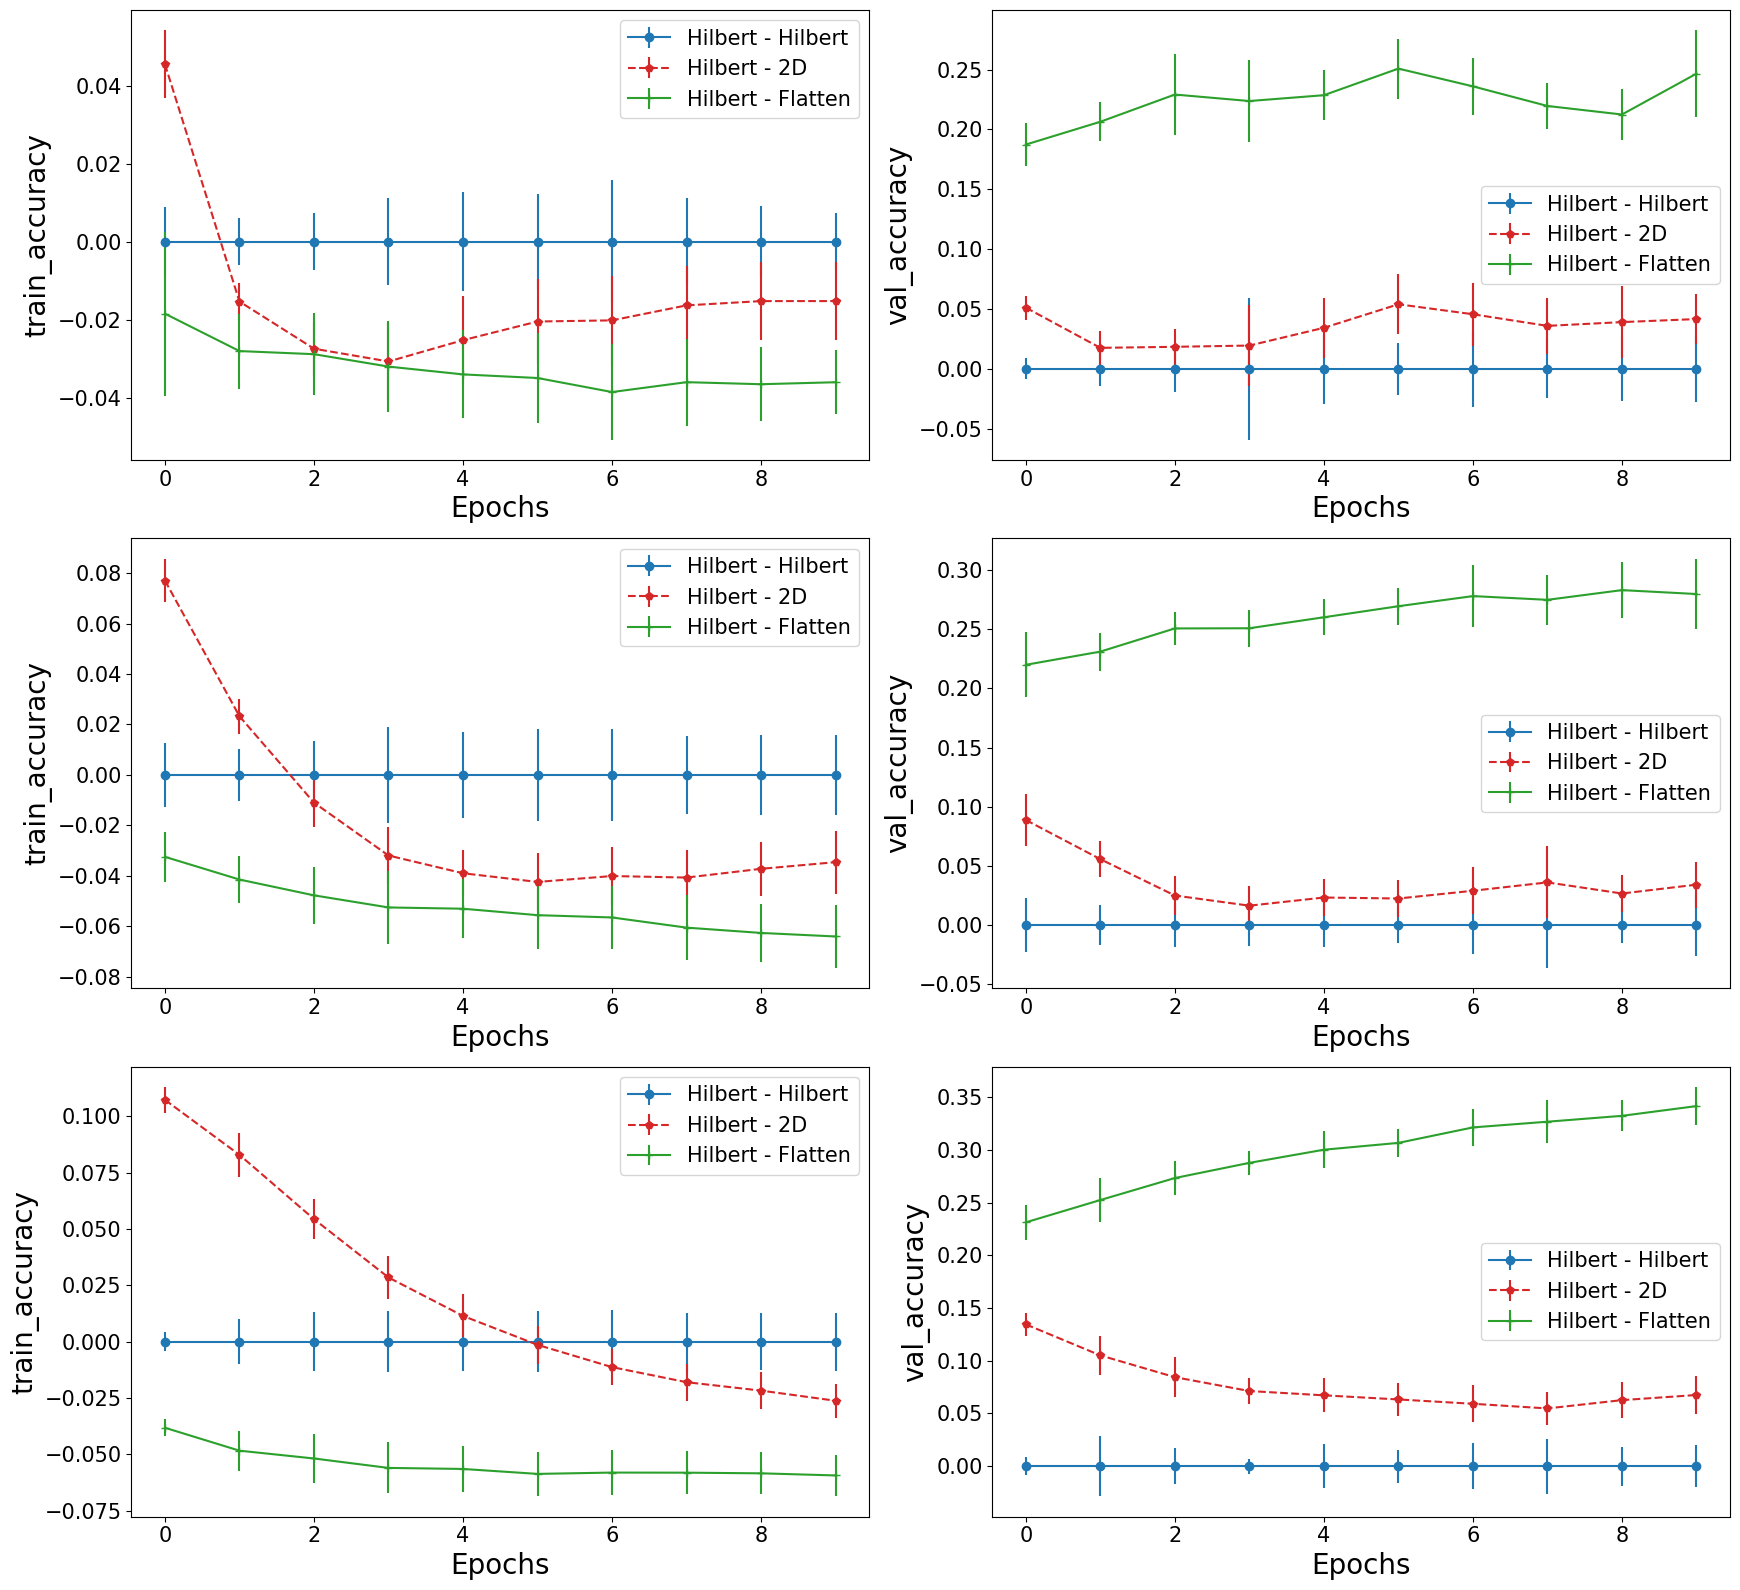

In [16]:
# if len(my_batches) > 1:
#     fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (len(my_batches)/2*17.5,2*9))
# else:
#     fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (2*17.5,8))
fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (17.5,2*8))

row_nb = 0
col_nb = 0

differences = {}

for my_batch in sorted(my_batches):
    color_index = 0
    col_nb = 0
    my_transforms = list(my_dataset[my_batch].keys())
    differences[my_batch] = {}
    for my_metric in my_metrics:
        legend_string = list()
        temp_exp_set = np.zeros((my_epochs))
        temp_var_set = np.zeros((my_epochs))
        sign = 1
        color_index = 0
        line_index = 0
        differences[my_batch][my_metric] = {}
        for my_transform in my_transforms:
            # if my_transform == "Hilbert":
            #     continue
            # else:
            my_runs = list(my_dataset[my_batch][my_transforms[0]].keys())
            temp_exp_set = np.array(expected_values[my_batch][my_metric]["Hilbert"]) - np.array(expected_values[my_batch][my_metric][my_transform])
            temp_var_set = np.array(variation_values[my_batch][my_metric]["Hilbert"]) + np.array(variation_values[my_batch][my_metric][my_transform])
                # my_runs = list(my_dataset[my_batch][my_transforms[0]].keys())
                # temp_exp_set += sign*(np.array(expected_values[my_batch][my_metric][my_transform]))
                # temp_var_set += np.array(variation_values[my_batch][my_metric][my_transform])
                # if sign:
                #     sign = -1

            differences[my_batch][my_metric][my_transform] = np.stack((temp_exp_set, temp_var_set))
            if len(my_batches) > 1:
                axs[row_nb][col_nb].errorbar(
                    range(my_epochs),
                    temp_exp_set,
                    temp_var_set,
                    color = my_colors[color_index],
                    linestyle = line_styles[line_index],
                    marker = my_markers[color_index],
                    label="Hilbert - "+my_transform
                    )
            else:
                axs[col_nb].errorbar(
                    range(my_epochs),
                    temp_exp_set,
                    temp_var_set,
                    color = my_colors[color_index],
                    linestyle = line_styles[line_index],
                    marker = my_markers[color_index],
                    label = "Hilbert - "+my_transform
                    )
            if len(my_batches) > 1:
                # axs[row_nb][col_nb].set_title(dataname+" Difference\nBatchsize: %i - %s" %(my_batch, my_metric), fontsize=ts)
                axs[row_nb][col_nb].set_xlabel("Epochs", fontsize=fs)
                axs[row_nb][col_nb].set_ylabel(my_metric, fontsize=fs)
                axs[row_nb][col_nb].tick_params(axis='both', labelsize=tick_size)
                axs[row_nb][col_nb].legend(handles=legend_string, frameon=True, loc='best', fontsize=ls)
                axs[row_nb][col_nb].legend(fontsize=ls)
            else:
                # axs[col_nb].set_title(dataname+" Difference\nBatchsize: %i - %s" %(my_batch, my_metric), fontsize=ts)
                axs[col_nb].set_xlabel("Epochs", fontsize=fs)
                axs[col_nb].set_ylabel(my_metric, fontsize=fs)
                axs[col_nb].tick_params(axis='both', labelsize=tick_size)
                axs[col_nb].legend(handles=legend_string, frameon=True, loc='best', fontsize=ls)
                axs[row_nb][col_nb].legend(fontsize=ls)
            color_index += 2
            if line_index:
                line_index = 0
            else:
                line_index = 1

        col_nb += 1
    row_nb += 1

fig.tight_layout()

if save_data:
    fig.savefig("Fig_3.png",dpi = 100, bbox_inches="tight")

fig.show()


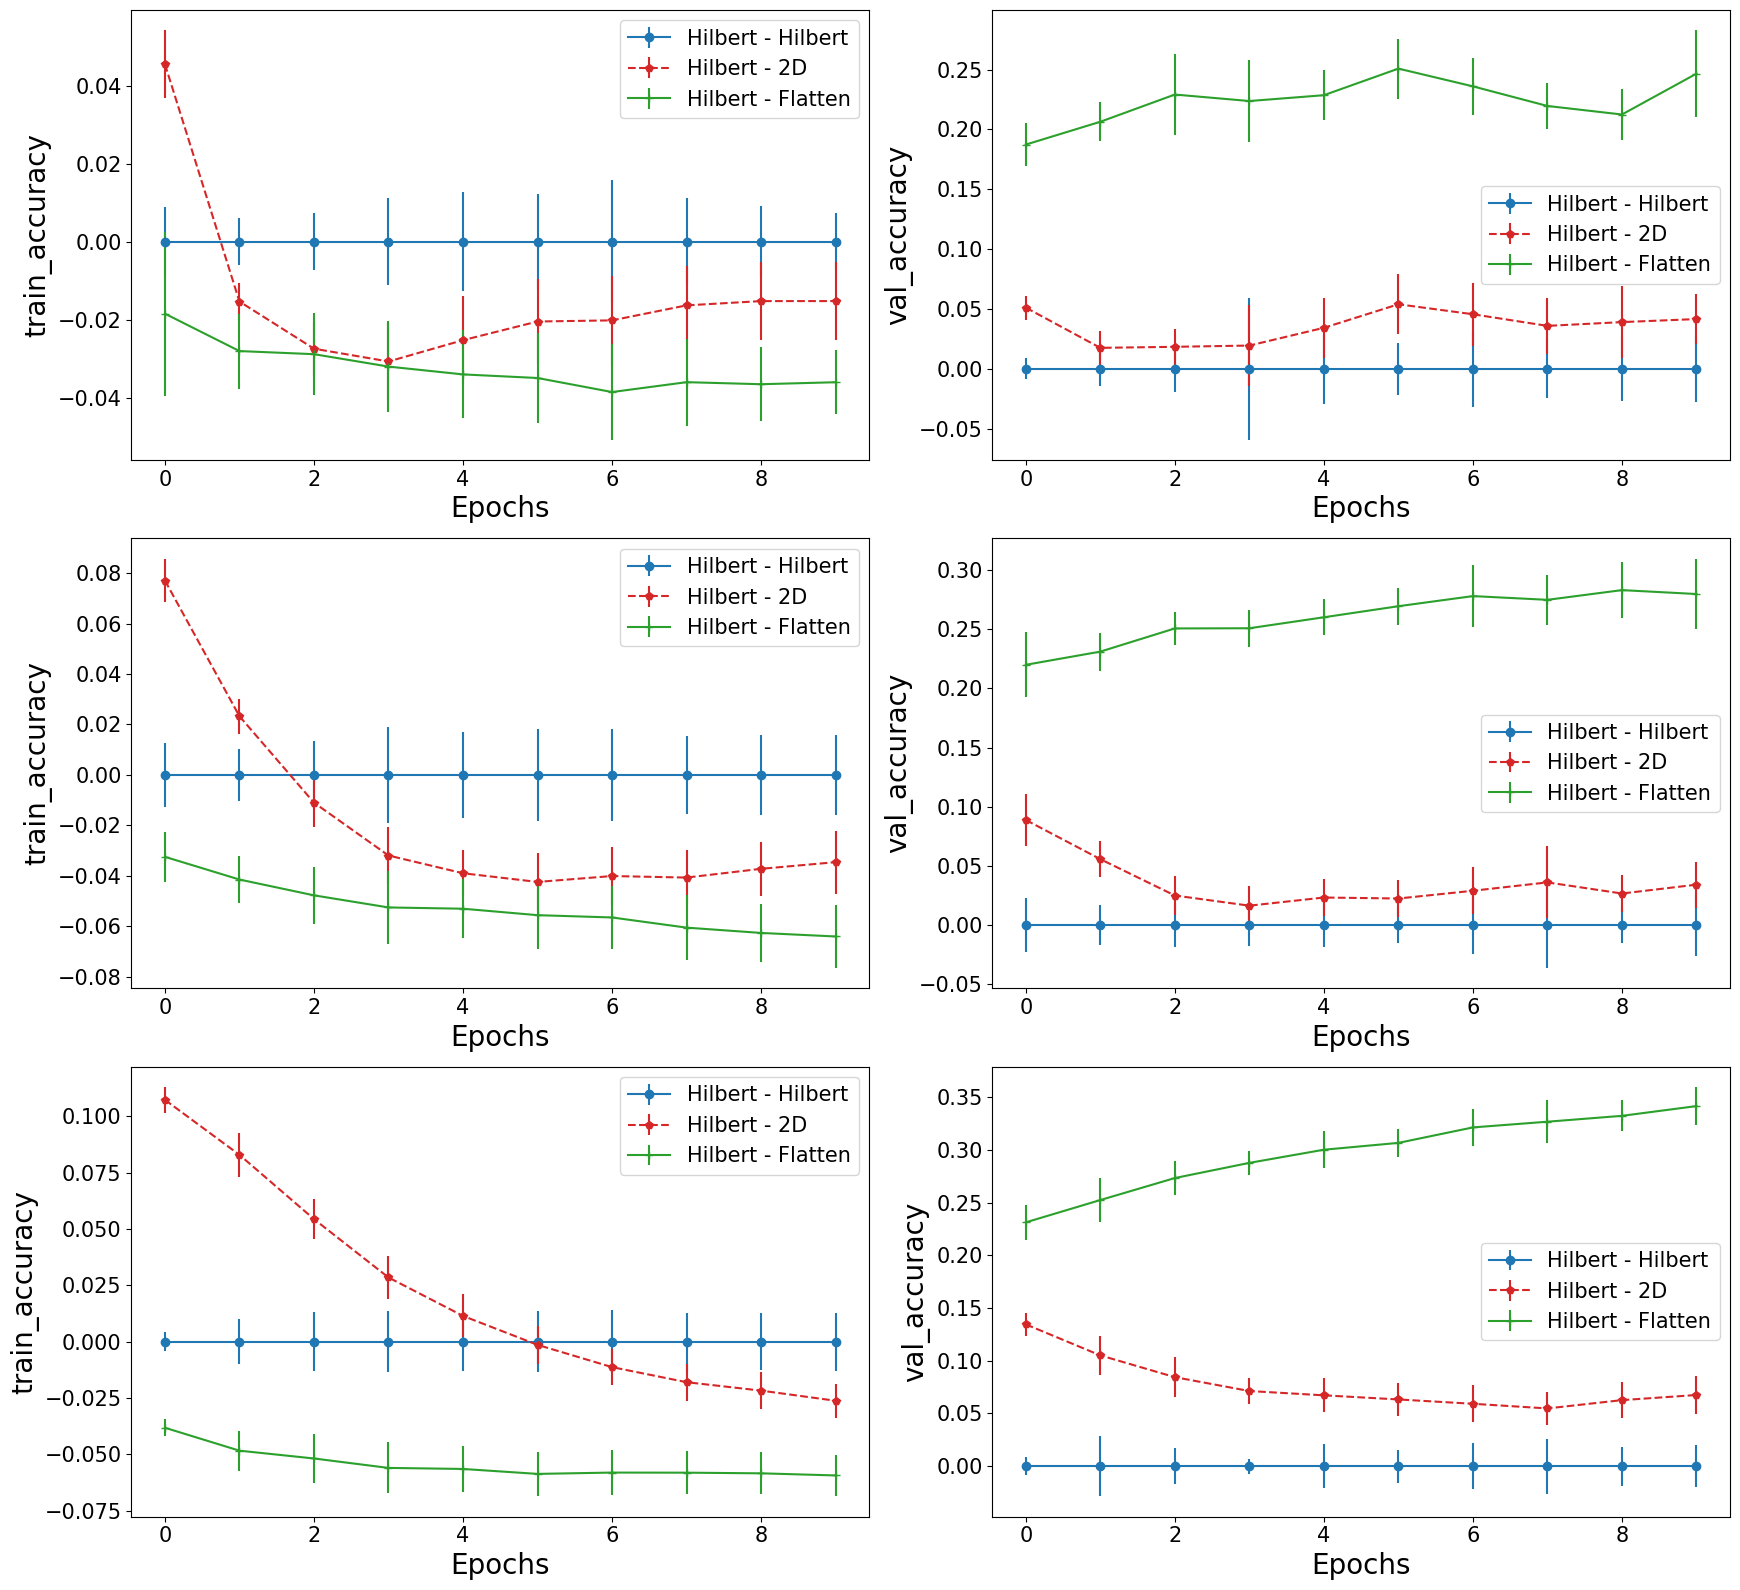

In [17]:
# if len(my_batches) > 1:
#     fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (len(my_batches)/2*17.5,2*9))
# else:
#     fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (2*17.5,8))
fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (17.5,2*8))

row_nb = 0
col_nb = 0

avg_differences = {}

for my_batch in sorted(list(averages.keys())):
    color_index = 0
    col_nb = 0
    my_metrics = list(averages[my_batch].keys())
    avg_differences[my_batch] = {}
    for my_metric in my_metrics:
        legend_string = list()
        color_index = 0
        line_index = 0
        avg_differences[my_batch][my_metric] = {}
        my_transforms = list(averages[my_batch][my_metric].keys())
        for my_transform in my_transforms:
            my_runs = list(my_dataset[my_batch][my_transforms[0]].keys())
            # avg_diff_set = np.array(averages[my_batch][my_metric]["Hilbert"]) - np.array(averages[my_batch][my_metric][my_transform])
            avg_differences[my_batch][my_metric][my_transform] = np.stack((np.subtract(averages[my_batch][my_metric]["Hilbert"][0],averages[my_batch][my_metric][my_transform][0]),
                                                                          np.add(averages[my_batch][my_metric]["Hilbert"][1],averages[my_batch][my_metric][my_transform][1])
                                                                          ))
            if len(my_batches) > 1:
                axs[row_nb][col_nb].errorbar(
                    range(my_epochs),
                    avg_differences[my_batch][my_metric][my_transform][0],
                    avg_differences[my_batch][my_metric][my_transform][1],
                    color = my_colors[color_index],
                    linestyle = line_styles[line_index],
                    marker = my_markers[color_index],
                    label="Hilbert - "+my_transform
                    )
            else:
                axs[col_nb].errorbar(
                    range(my_epochs),
                    avg_differences[my_batch][my_metric][my_transform][0],
                    avg_differences[my_batch][my_metric][my_transform][1],
                    color = my_colors[color_index],
                    linestyle = line_styles[line_index],
                    marker = my_markers[color_index],
                    label = "Hilbert - "+my_transform
                    )
            if len(my_batches) > 1:
                # axs[row_nb][col_nb].set_title(dataname+" Difference\nBatchsize: %i - %s" %(my_batch, my_metric), fontsize=ts)
                axs[row_nb][col_nb].set_xlabel("Epochs", fontsize=fs)
                axs[row_nb][col_nb].set_ylabel(my_metric, fontsize=fs)
                axs[row_nb][col_nb].tick_params(axis='both', labelsize=tick_size)
                axs[row_nb][col_nb].legend(handles=legend_string, frameon=True, loc='best', fontsize=ls)
                axs[row_nb][col_nb].legend(fontsize=ls)
            else:
                # axs[col_nb].set_title(dataname+" Difference\nBatchsize: %i - %s" %(my_batch, my_metric), fontsize=ts)
                axs[col_nb].set_xlabel("Epochs", fontsize=fs)
                axs[col_nb].set_ylabel(my_metric, fontsize=fs)
                axs[col_nb].tick_params(axis='both', labelsize=tick_size)
                axs[col_nb].legend(handles=legend_string, frameon=True, loc='best', fontsize=ls)
                axs[row_nb][col_nb].legend(fontsize=ls)
            color_index += 2
            if line_index:
                line_index = 0
            else:
                line_index = 1

        col_nb += 1
    row_nb += 1

fig.tight_layout()

if save_data:
    fig.savefig(dataname+"_"+modelname+"_Differences.pdf", format='pdf', dpi = 100, bbox_inches="tight")

fig.show()


# Finale Formatted Figures

## Formatting options

In [18]:
# Figure Formatting:
####################
def set_figure_size(row, col):
    width = 17.5*int(row/2)+1
    height= 8*int(col/2)+1
    return (width,height)

figure_size = (17.5,8)

# font sizes
fs = 20 #fontsize
ts = 25/2  #titlesize
ls = 15  #legendsize
tick_size = 15

# visual settings
ms = 10/4
lw = 2/2

# Markers and linetypes
my_markers = ['o','s','p','h','+','x','v','>','<','^']
line_styles = ["solid","dashed","dotted","dashdot"]
my_colors = ["C0","C9", "C3","C6","C2","C8"]

# Unified parameters:
markers = {}
markers["Hilbert"] = ["o","D","v"]
markers["Flatten"] = ["s","^",">"]
markers["2D"]      = ["p","*","X"]
colors = {}
colors["Hilbert"] = [(106/256,139/256,206/256), (141/256, 173/256, 63/256), (132/256, 119/256, 175/256)]
colors["Flatten"] = [(226/256, 157/256, 36/256),(238/256, 93/256, 38/256),(170/256, 132/256, 87/256)]
colors["2D"]      = ["C9", "C6", 'black']
lines = {}
lines["Hilbert"] = ("solid","dashed","dotted")
lines["Flatten"] = ("solid","dashed","dotted")
lines["2D"] = ("solid","dashed","dotted")

legend_labels = {}

m_it = 0
for my_transform in my_transforms:
    m_it = 0
    legend_labels[my_transform + modelname] = {}
    legend_labels[my_transform + modelname]["label"] = "%s- Model %s" %(my_transform,modelname)
    legend_labels[my_transform + modelname]["color"] = colors[my_transform][m_it]
    legend_labels[my_transform + modelname]["marker"] = markers[my_transform][m_it]
    legend_labels[my_transform + modelname]["linetype"] = lines[my_transform][m_it]
    m_it+=1


# Axis labels:
my_metric_name = {}
my_metric_name["train_accuracy"]       = "training accuracy"
my_metric_name["train_loss"]           = "training loss"
my_metric_name["train_top_k_accuracy"] = "training top-5 accuracy"
my_metric_name["val_accuracy"]         = "validation accuracy"
my_metric_name["val_loss"]             = "validation loss"
my_metric_name["val_top_k_accuracy"]   = "validation top-5 accuracy"

## Results

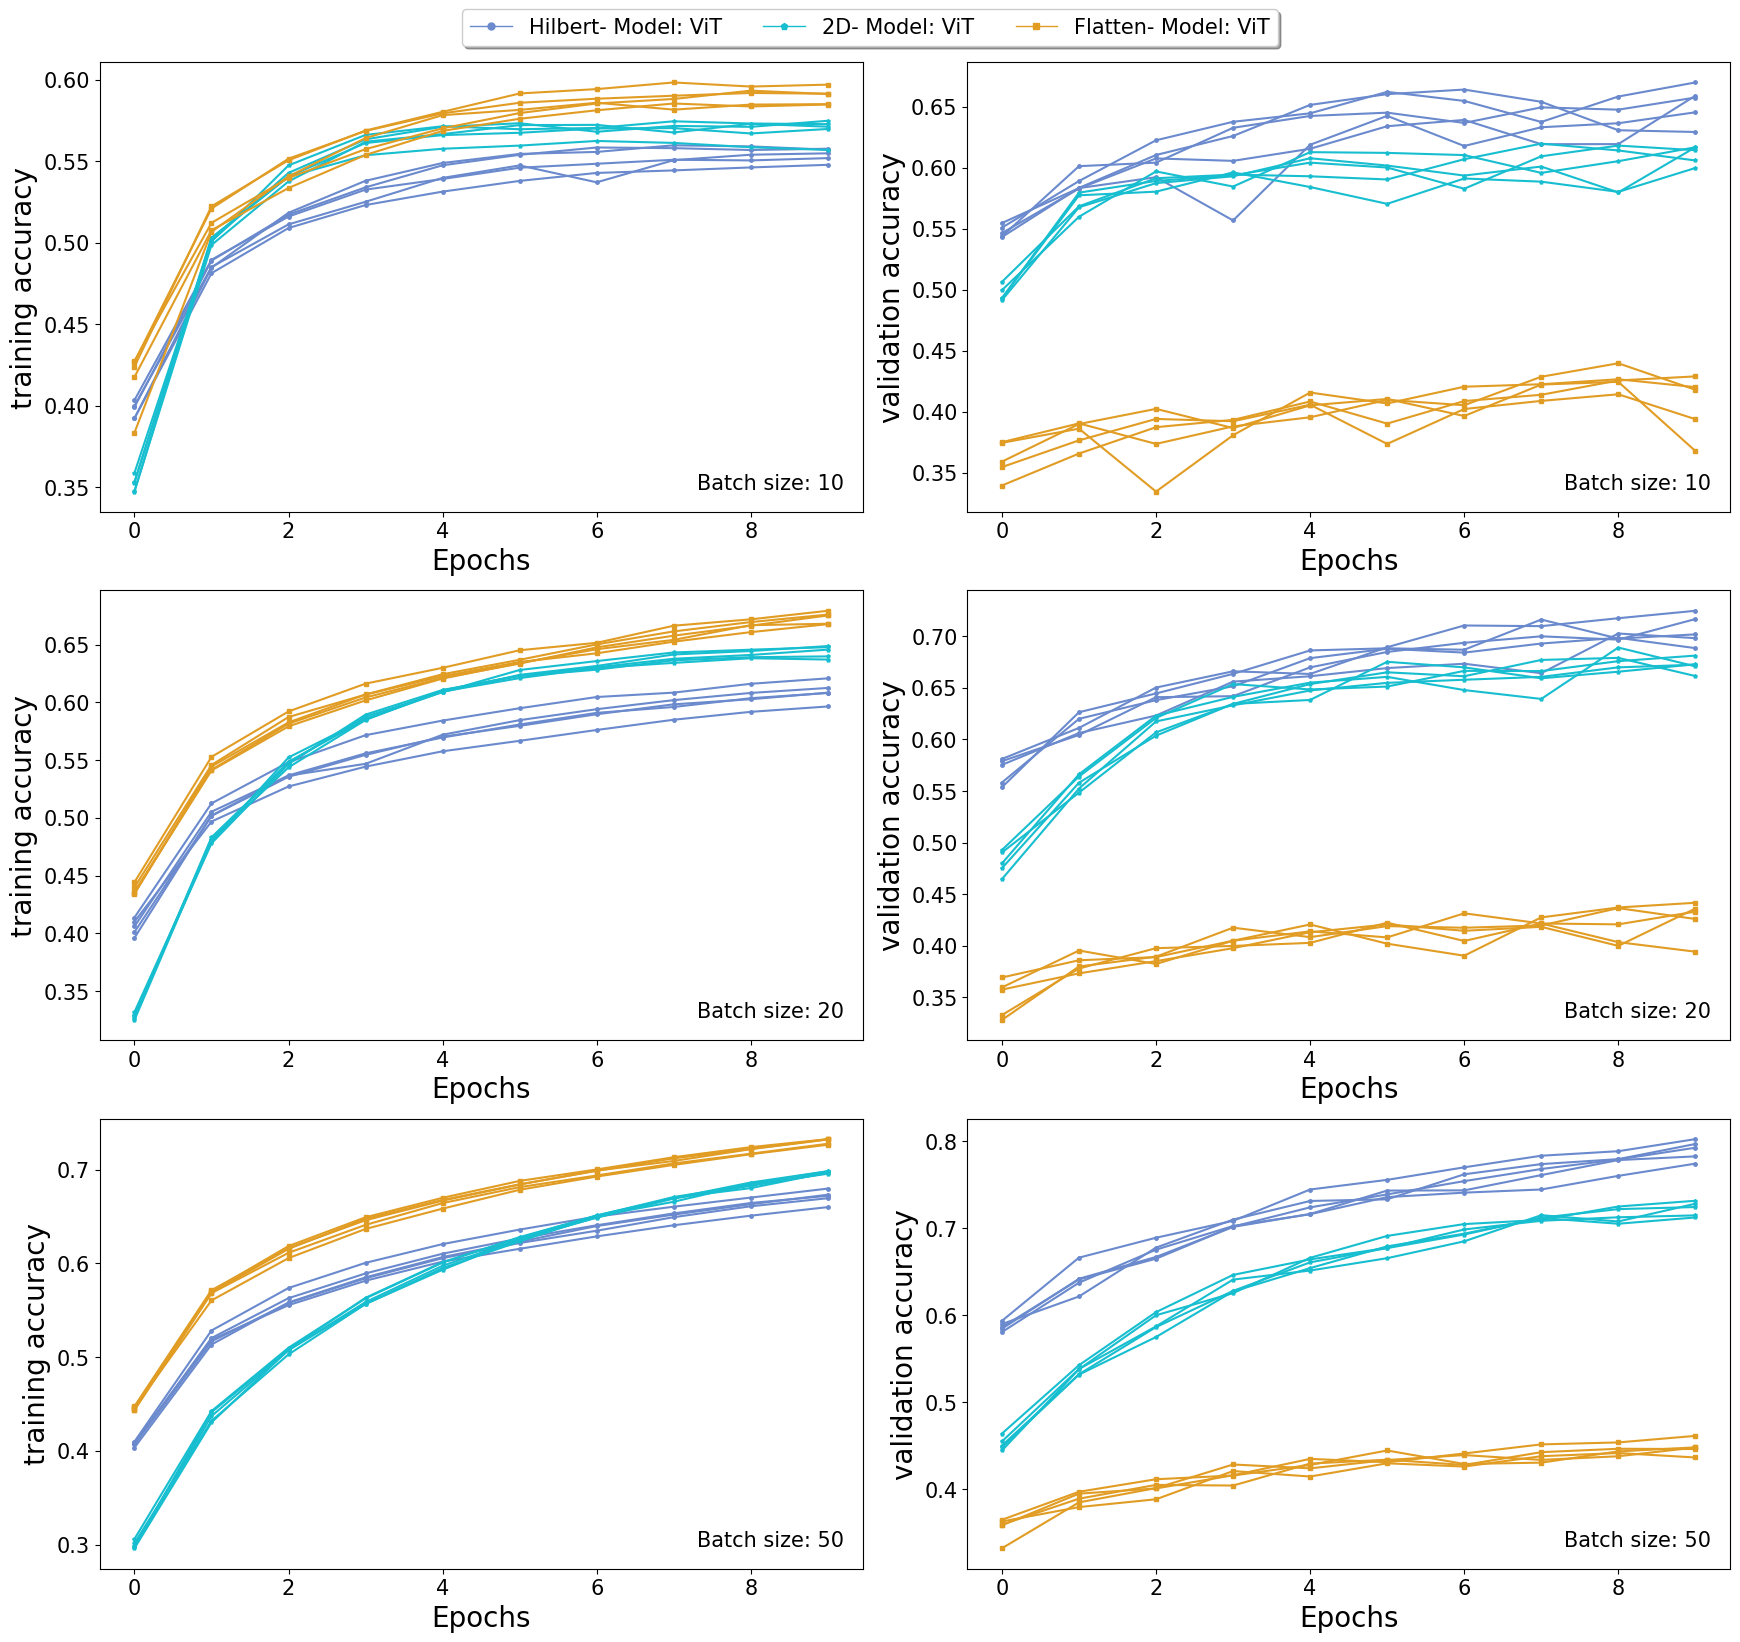

In [19]:
# fig, axs = plt.subplots(len(my_batches),len(my_metrics[:-1]), figsize= set_figure_size(len(my_batches),len(my_metrics[:-1])))
my_batches = list(my_dataset.keys())[1:]
fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (17.5,2*8))
min_epochs = my_epochs

row_nb = 0
col_nb = 0
label_set = {}

for my_batch in sorted(my_batches):
    color_index = 0
    col_nb = 0
    my_transforms = list(my_dataset[my_batch].keys())
    for my_metric in my_metrics:
        legend_string = list()
        color_index = 0
        for my_transform in my_transforms:
            line_index = 0
            # for my_model in list(my_dataset[my_batch][my_transform].keys()):
            my_runs = list(my_dataset[my_batch][my_transform].keys())
            for my_run in my_runs:
                my_epochs = len(my_dataset[my_batch][my_transform][my_run][my_metric])
                ## Transformation 1
                axs[row_nb][col_nb].plot(
                    range(min_epochs),
                    my_dataset[my_batch][my_transform][my_run][my_metric][:min_epochs],
                    color = legend_labels[my_transform+modelname]["color"],
                    marker = legend_labels[my_transform+modelname]["marker"],
                    linestyle=legend_labels[my_transform+modelname]["linetype"],
                    markersize = ms
                    )
            my_label = "%s- Model: %s" %(my_transform,modelname)
            my_line = Line2D([0], [0],
                                color = legend_labels[my_transform+modelname]["color"],
                                marker = legend_labels[my_transform+modelname]["marker"],
                                linestyle=legend_labels[my_transform+modelname]["linetype"],
                                markersize = ms*2,
                                lw=1,
                                label= my_label
                                )
            if my_label not in list(label_set.keys()):
                label_set[my_label] = my_line

            color_index += 1
            if line_index:
                line_index = 0
            else:
                line_index = 1

            # axs[row_nb][col_nb].set_title("Batchsize: %i - %s" %(my_batch, my_metric), fontsize=ts)
            axs[row_nb][col_nb].set_xlabel("Epochs", fontsize=fs)
            axs[row_nb][col_nb].set_ylabel(my_metric_name[my_metric], fontsize=fs)
            axs[row_nb][col_nb].tick_params(axis='both', labelsize=tick_size)
            axs[row_nb][col_nb].legend(handles=[Line2D([0],[0],linestyle="",marker="",label = "Batch size: %i" %my_batch)], frameon=False, loc='lower right', fontsize=ls)
            # axs[row_nb][col_nb].legend(handles=legend_string, frameon=True, loc='best', fontsize=ls)
            # axs[row_nb][col_nb].legend(fontsize=ls)

        col_nb += 1
    row_nb += 1

for my_line_object in label_set.values():
    legend_string.append(my_line_object)

fig.legend(handles=legend_string, frameon=True, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=len(my_transforms), fancybox=True, shadow=True, fontsize=ls)
fig.tight_layout()

if save_data:
    fig.savefig(target_dir+dataname+"_"+modelname+"_Results.pdf", format='pdf', dpi = 100, bbox_inches="tight")

fig.show()


## Averaged Results

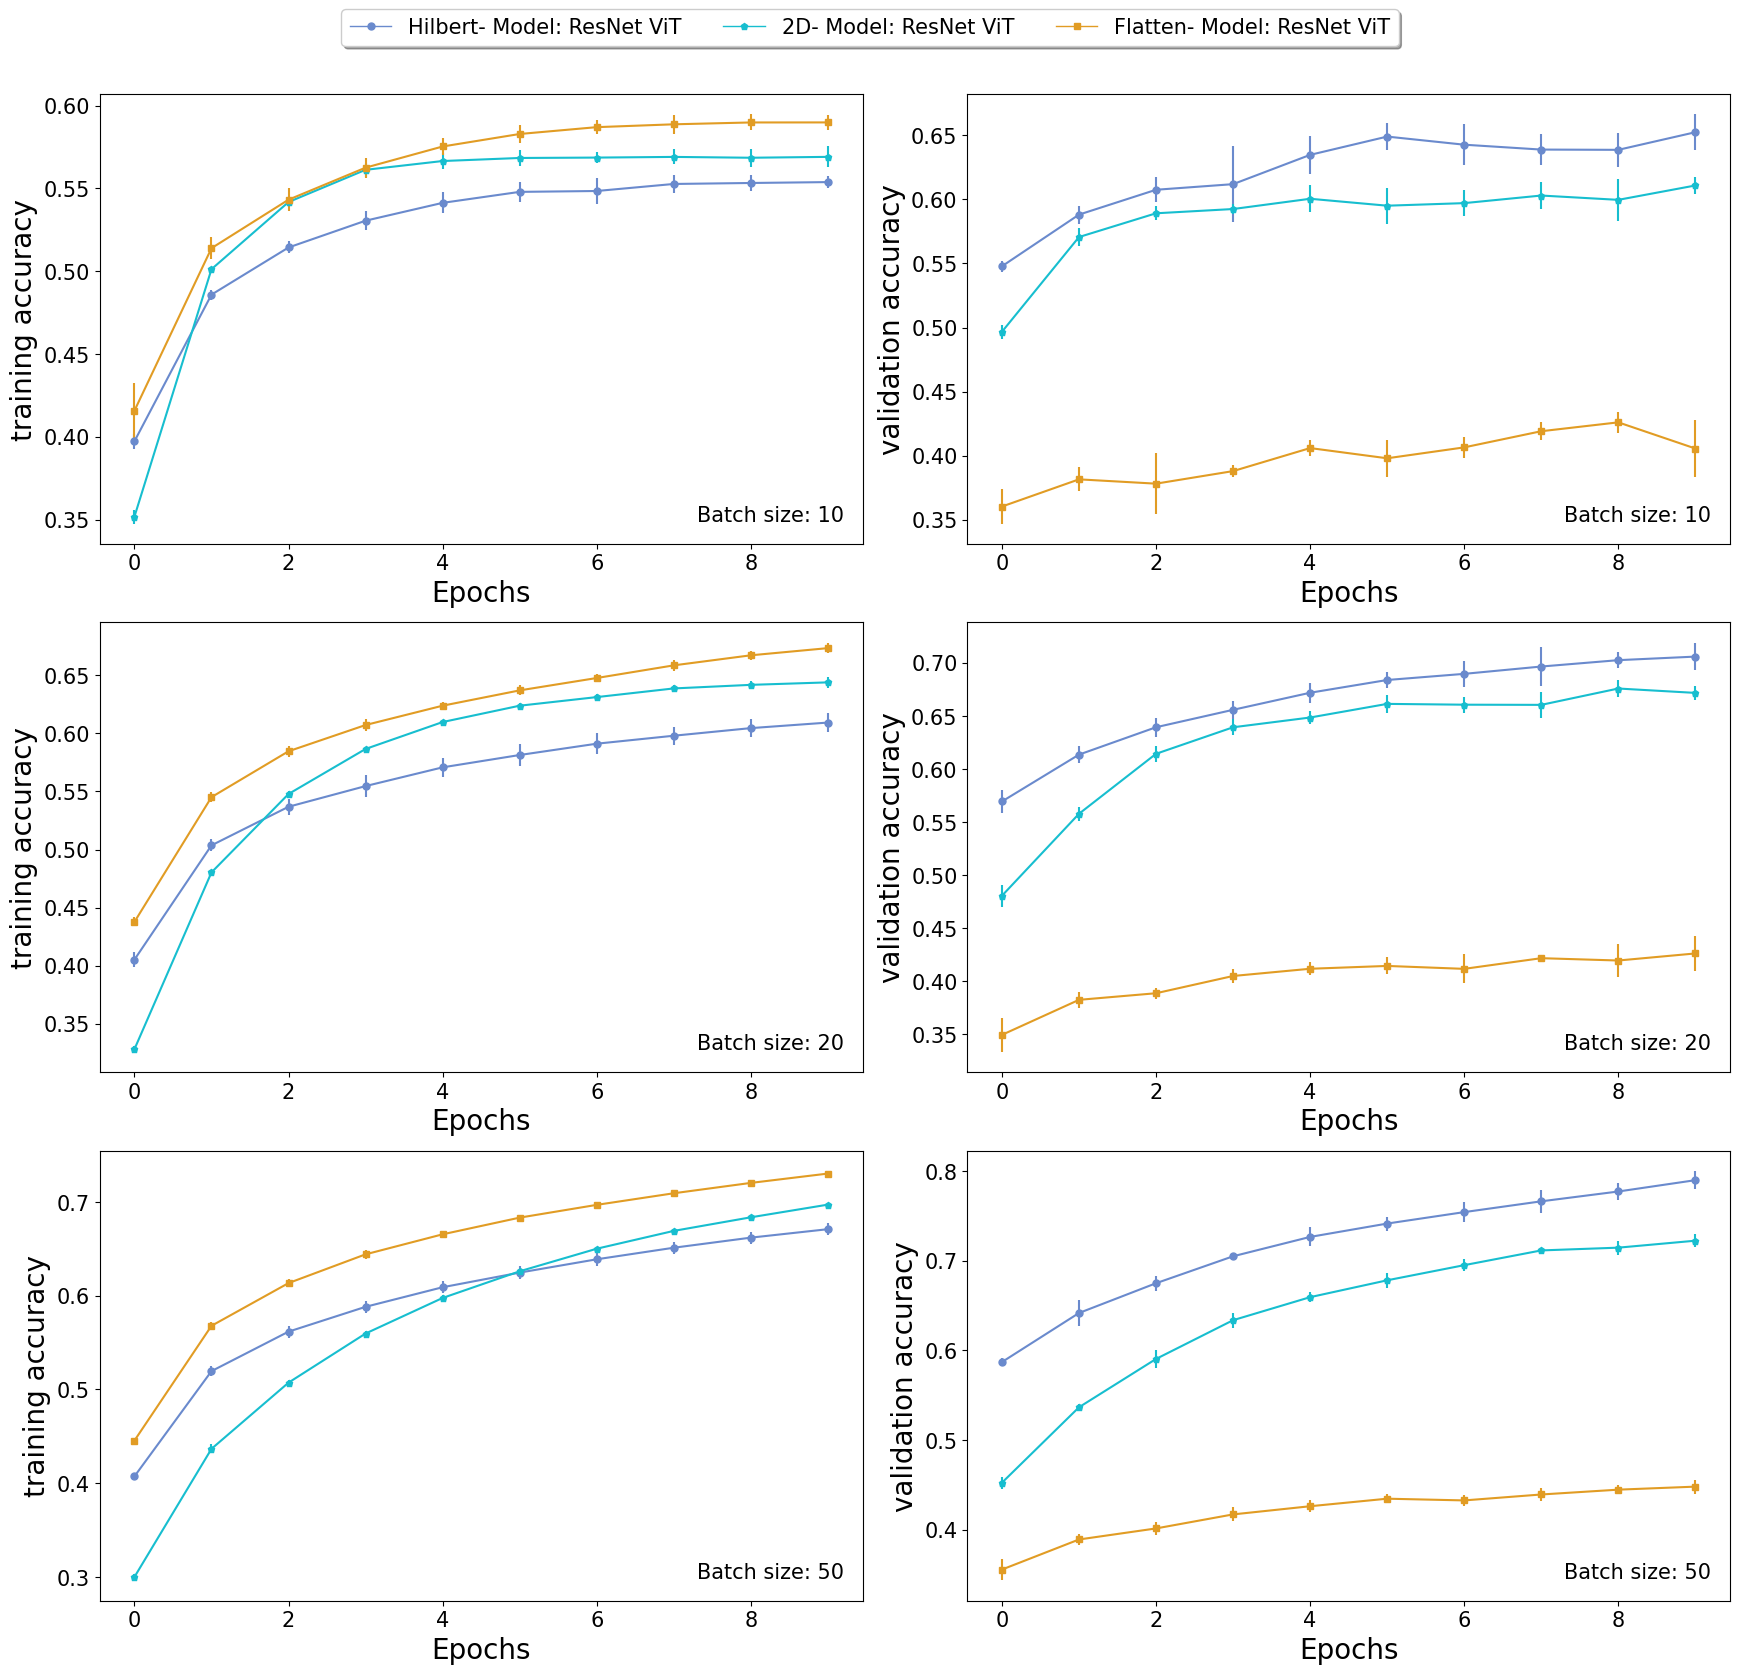

In [20]:
# fig, axs = plt.subplots(len(my_batches),len(my_metrics[:-1]), figsize= set_figure_size(len(my_batches),len(my_metrics[:-1])))
# if len(my_batches) > 1:
#     fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (len(my_batches)*17.5,2*9))
# else:
#     fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (2*17.5,8))

fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (17.5,2*8))

row_nb = 0
col_nb = 0

expected_values  = {}
variation_values = {}
label_set = {}

for my_batch in sorted(my_batches):
    color_index = 0
    col_nb = 0
    my_transforms = list(my_dataset[my_batch].keys())
    expected_values[my_batch]  = {}
    variation_values[my_batch] = {}
    for my_metric in my_metrics:
        legend_string = list()
        color_index = 0
        expected_values[my_batch][my_metric]  = {}
        variation_values[my_batch][my_metric] = {}
        for my_transform in my_transforms:
            expected_values[my_batch][my_metric][my_transform]  = list()
            variation_values[my_batch][my_metric][my_transform] = list()
            line_index = 0
            my_runs = list(my_dataset[my_batch][my_transform].keys())
            my_epochs = min(len(my_dataset[my_batch][my_transform][my_run][my_metric]) for my_run in my_runs)

            exp_vals = list()
            var_vals = list()
            # for my_range in range(my_epochs):
            for my_range in range(min_epochs):
                my_exp_val, my_var = norm.fit([my_dataset[my_batch][my_transform][my_run][my_metric][my_range] for my_run in my_runs])
                exp_vals.append(my_exp_val)
                var_vals.append(my_var)
            if len(my_batches) > 1:
                axs[row_nb][col_nb].errorbar(
                    #range(int(my_epochs/2),my_epochs),
                    # range(my_epochs),
                    range(min_epochs),
                    exp_vals,
                    var_vals,
                    color = legend_labels[my_transform+modelname]["color"],
                    marker = legend_labels[my_transform+modelname]["marker"],
                    linestyle=legend_labels[my_transform+modelname]["linetype"],
                    markersize = ms*2
                    )
            else:
                axs[col_nb].errorbar(
                    # range(int(my_epochs/2),my_epochs),
                    # range(my_epochs),
                    range(min_epochs),
                    exp_vals,
                    var_vals,
                    color = legend_labels[my_transform+modelname]["color"],
                    marker = legend_labels[my_transform+modelname]["marker"],
                    linestyle=legend_labels[my_transform+modelname]["linetype"],
                    markersize = ms*2
                    )
            expected_values[my_batch][my_metric][my_transform]  = exp_vals
            variation_values[my_batch][my_metric][my_transform] = var_vals

            my_label = "%s- Model: ResNet %s" %(my_transform,modelname)
            my_line = Line2D([0], [0],
                                color = legend_labels[my_transform+modelname]["color"],
                                marker = legend_labels[my_transform+modelname]["marker"],
                                linestyle=legend_labels[my_transform+modelname]["linetype"],
                                markersize = ms*2,
                                lw=1,
                                label= my_label
                                )
            if my_label not in list(label_set.keys()):
                label_set[my_label] = my_line

            color_index += 1
            if line_index:
                line_index = 0
            else:
                line_index = 1

            if len(my_batches) > 1:
                # axs[row_nb][col_nb].set_title(dataname+"/nBatchsize: %i - %s" %(my_batch, my_metric), fontsize=ts)
                axs[row_nb][col_nb].set_xlabel("Epochs", fontsize=fs)
                axs[row_nb][col_nb].set_ylabel(my_metric_name[my_metric], fontsize=fs)
                axs[row_nb][col_nb].tick_params(axis='both', labelsize=tick_size)
                axs[row_nb][col_nb].legend(handles=[Line2D([0],[0],linestyle="",marker="",label = "Batch size: %i" %my_batch)], frameon=False, loc='lower right', fontsize=ls)
                # axs[row_nb][col_nb].legend(handles=legend_string, frameon=True, loc='best', fontsize=ls)
                # axs[row_nb][col_nb].legend(fontsize=ls)
            else:
                # axs[col_nb].set_title(dataname+"/nBatchsize: %i - %s" %(my_batch, my_metric), fontsize=ts)
                axs[col_nb].set_xlabel("Epochs", fontsize=fs)
                axs[col_nb].set_ylabel(my_metric_name[my_metric], fontsize=fs)
                axs[col_nb].tick_params(axis='both', labelsize=tick_size)
                axs[col_nb].legend(handles=[Line2D([0],[0],linestyle="",marker="",label = "Batch size: %i" %my_batch)], frameon=False, loc='lower right', fontsize=ls)
                # axs[col_nb].legend(handles=legend_string, frameon=True, loc='best', fontsize=ls)
                # axs[row_nb][col_nb].legend(fontsize=ls)

        col_nb += 1
    row_nb += 1

for my_line_object in label_set.values():
    legend_string.append(my_line_object)

fig.legend(handles=legend_string, frameon=True, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(my_transforms), fancybox=True, shadow=True, fontsize=ls)
fig.tight_layout()

if save_data:
    fig.savefig(target_dir+dataname+"_"+modelname+"_Averaged_ES.pdf", format='pdf', dpi = 100, bbox_inches="tight")

fig.show()


## Validation Difference

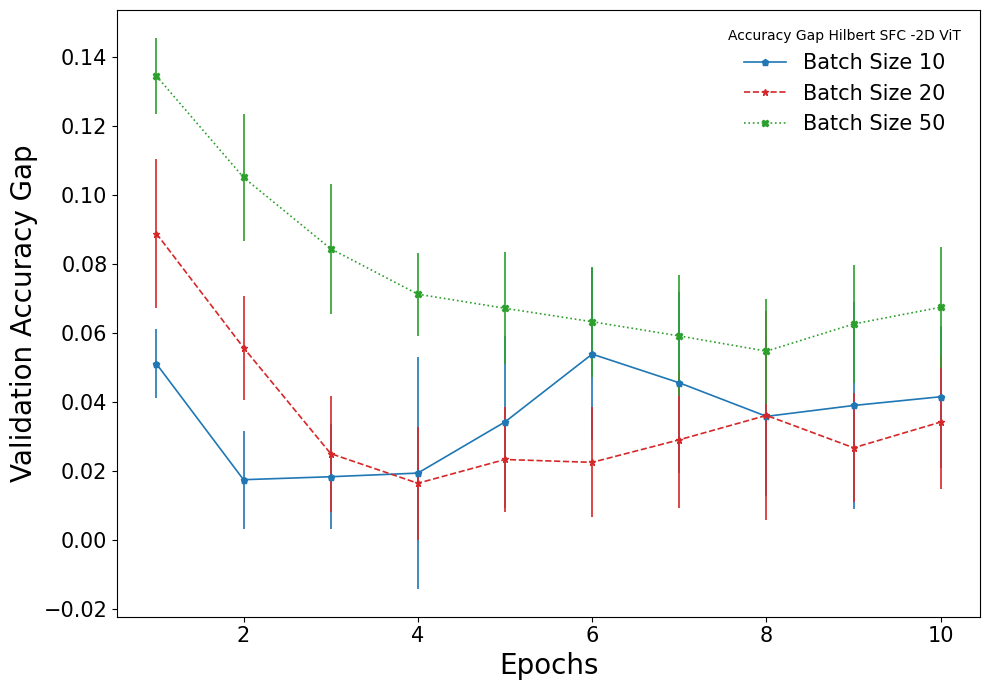

In [26]:
# fig, axs = plt.subplots(len(my_batches),len(my_metrics), figsize= (17.5,2*8))
fig = plt.figure(figsize= (10,7))

my_metric = "val_accuracy"
my_transform = "2D"
my_legend = list()
color_index = 0
line_index = 0

for my_batch in sorted(list(averages.keys())):
    my_metrics = list(averages[my_batch].keys())
    plt.errorbar(
            range(1,my_epochs+1),
            avg_differences[my_batch][my_metric][my_transform][0],
            avg_differences[my_batch][my_metric][my_transform][1],
            # color       = colors[my_transform][color_index],
            color       = my_colors[color_index],
            marker      = markers[my_transform][line_index],
            linestyle   = lines[my_transform][line_index],
            markersize = ms*2,
            lw = 1.2
            # label = "Accuracy Gap\nBatch %i" %my_batch
            )
    my_label = "Batch Size %i" %my_batch
    my_legend.append(Line2D([0],[0],
                    # color       = colors[my_transform][color_index],
                    color       = my_colors[color_index],
                    marker      = markers[my_transform][line_index],
                    linestyle   = lines[my_transform][line_index],
                    markersize = ms*2,
                    lw=1.2,
                    label= my_label)
    )
    color_index += 2
    line_index += 1

plt.xlabel("Epochs", fontsize=fs)
plt.ylabel("Validation Accuracy Gap", fontsize=fs)
plt.tick_params(axis='both', labelsize=tick_size)
plt.legend(handles=my_legend, frameon=False, loc='upper right', fontsize=ls, title="Accuracy Gap Hilbert SFC -2D ViT")
fig.tight_layout()

if save_data:
    fig.savefig(dataname+"_"+modelname+"_validationGap.pdf", format='pdf', dpi = 100, bbox_inches="tight")

fig.show()


## Output data objects

In [22]:
## Only average data output to start from
if 0:
    import csv
    export_directory = "Mathematica"
    print("Writing %s to directory %s" %(export_directory,os.getcwd()))

    for my_batch in list(my_dataset.keys())[1:]:
        my_transforms = list(my_dataset[my_batch].keys())
        for my_transform in my_transforms:
            my_runs = list(my_dataset[my_batch][my_transform].keys())
            my_metrics = list(my_dataset[my_batch][my_transform][my_runs[0]].keys())
            for my_metric in my_metrics:
                with (open(export_directory+"/Data_"+str(my_batch)+"_"+my_transform+"_"+my_metric+".csv","w")) as handle:
                    writer = csv.writer(handle)
                    writer.writerow([my_batch, my_transform, my_metric])
                    writer.writerows([my_dataset[my_batch][my_transform][my_run][my_metric] for my_run in my_runs])
                    handle.close()


In [23]:
averages[50]['train_accuracy']["Hilbert"][0]

array([0.40730158, 0.51958921, 0.56171428, 0.58821015, 0.60910221,
       0.62470794, 0.63891047, 0.65124507, 0.66200826, 0.67102667])

In [24]:
import csv
export_directory = "$YOUR EXPORT DIRECTORY FOR csv DATA HERE$"
print("Writing %s to directory %s" %(export_directory,os.getcwd()))

with (open(export_directory+"/Averages_ViTCifar10.csv","w")) as handle:
    writer = csv.writer(handle)
    for my_batch in list(averages.keys()):
        my_metrics = list(averages[my_batch].keys())
        for my_metric in my_metrics:
            my_transforms = list(averages[my_batch][my_metric].keys())
            for my_transform in my_transforms:
                my_line = [my_batch, my_metric, my_transform, "Avg"]
                my_line += list(averages[my_batch][my_metric][my_transform][0])
                writer.writerow(my_line)
                my_line = [my_batch, my_metric, my_transform, "Var"]
                my_line += list(averages[my_batch][my_metric][my_transform][1])
                writer.writerow(my_line)
handle.close()

Writing Mathematica to directory /content/drive/MyDrive/AI_Research/Hilbert_AppliedIntelligence/ViT/Cluster_results/Cifar10
